In [173]:
import matplotlib.pyplot as plt
import os
import numpy as np
from stompy.spatial import field, wkb2shp 
from stompy import utils
from stompy.plot import plot_wkb
from IPython.display import display,display_html
from scipy.ndimage import label
import pandas as pd
import glob

%matplotlib inline

In [174]:
# Read in the bounding areas first, so we can pull subsets of
# the DEM instead of loading the whole thing

suisun_cmp="/media/cws/Arc_Hydro/Suisun_CMP"
dem_src=os.path.join(suisun_cmp,"DEMs/Composite/DEM_VegCorr_DWR_2m_NAVD88.tif")

First_Mallard

'/media/cws/Arc_Hydro/Suisun_CMP/DEMs/Slough_boundingAreas/First_Mallard_bounding_area.shp'

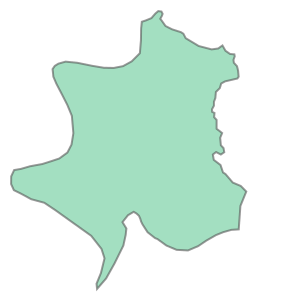

HillSlough

'/media/cws/Arc_Hydro/Suisun_CMP/DEMs/Slough_boundingAreas/HillSlough_bounding_area.shp'

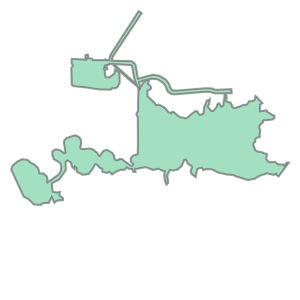

Peytonia

'/media/cws/Arc_Hydro/Suisun_CMP/DEMs/Slough_boundingAreas/Peytonia_bounding_area.shp'

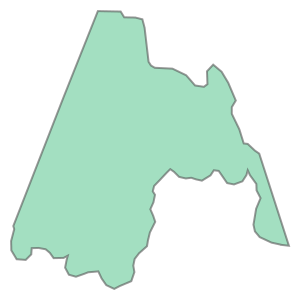

Sheldrake

'/media/cws/Arc_Hydro/Suisun_CMP/DEMs/Slough_boundingAreas/Sheldrake_bounding_area.shp'

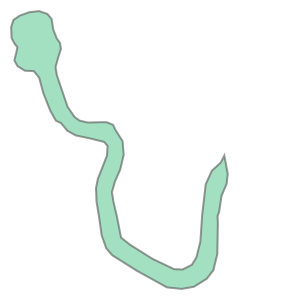

In [175]:
shps=glob.glob(os.path.join(suisun_cmp,"DEMs/Slough_boundingAreas/*.shp"))

recs=[]

for shp in shps:
    data=wkb2shp.shp2geom(shp)
    assert len(data)==1

    rec=dict(shp=shp,geom=data['geom'][0])
    slough_name=os.path.basename(shp).replace('_bounding_area.shp','')
    rec['name']=slough_name
    recs.append(rec)
    display_html(f"<b>{rec['name']}</b>",raw=True)
    display(shp)
    display(rec['geom'])
    
df_polys=pd.DataFrame(recs).set_index('name')
                 


In [176]:
def set_dem_crop(rec):
    # Get the overlapping portion of the DEM
    # This is pretty slow, though.  Maybe bounds are not correct
    # order
    xyxy=rec['geom'].bounds
    dem_crop=field.GdalGrid(dem_src,geo_bounds=[xyxy[0],xyxy[2],xyxy[1],xyxy[3]])
   
    # Mask the region outside the bounds
    in_poly=dem_crop.polygon_mask(poly=rec['geom'])
    dem_crop.F[~in_poly]=np.nan
    rec['dem_crop']=dem_crop

def set_pourpoint(rec):
    # Find lowest point, which will be the pour point
    rows,cols=np.nonzero( rec['dem_crop'].F==np.nanmin(rec['dem_crop'].F) )
    rec['pour_rowcol']=(rows[0],cols[0])
    x,y=rec['dem_crop'].xy()
    rec['pour_xy']=[x[cols[0]],y[rows[0]]]
    
def set_hypso(rec):
    # Calculate hypsometry in the usual way
    dem_crop=rec['dem_crop']
    valid=np.isfinite(dem_crop.F)
    elevations=dem_crop.F[valid]
    Apixel=np.abs(dem_crop.dx*dem_crop.dy)
    elevations.sort()
    cumul_area=(1+np.arange(len(elevations)))*Apixel
    z_area=np.c_[elevations,cumul_area]
    rec['area_hypso']=z_area
    return z_area

def set_connectivity(rec,dz=0.001):
    dem_crop=rec['dem_crop']
    pour_rowcol=rec['pour_rowcol']
    
    # And accounting for connectivity. Will recalculate regular 
    # hypsometry, too, for some extra assurance that it's doing
    # what I think it's doing.
    areas_hypso=[]
    areas_conn =[]

    invalid=~np.isfinite(dem_crop.F)
    F=dem_crop.F.copy()
    F[invalid]=np.inf

    sample_elevations=np.arange(F[~invalid].min(),F[~invalid].max(),dz)

    for z in utils.progress(sample_elevations,func=print):
        wet=F<=z
        areas_hypso.append( wet.sum() * Apixel)
        labels,n_labels=label(wet)
        # What label was given to the pour point?
        pour_label=labels[pour_rowcol]
        # and how many pixels got that label?
        areas_conn.append( (labels==pour_label).sum()*Apixel )
        
    areas_hypso=np.c_[sample_elevations, np.array(areas_hypso)] 
    areas_conn=np.c_[sample_elevations, np.array(areas_conn)]
    rec['area_hypso2']=areas_hypso
    rec['area_conn']=areas_conn
    return areas_hypso,areas_conn

def recipe(rec,dz=0.001):
    set_dem_crop(rec)
    set_pourpoint(rec)
    set_hypso(rec)
    set_connectivity(rec,dz=dz)
    
recipe(rec,dz=0.01)

In [177]:
def summary_figure(rec):
    fig,axs=plt.subplots(1,2,figsize=(10,6))
    rec['dem_crop'].plot(ax=axs[0],cmap='jet')
    plot_wkb.plot_wkb(rec['geom'],facecolor='none',ec='k',ax=axs[0])
    axs[0].text(rec['pour_xy'][0],rec['pour_xy'][1],"POUR",ha='center',va='center')
    axs[0].axis('off')

    ax=axs[1]
    ax.plot(rec['area_hypso'][:,1]/1e6,rec['area_hypso'][:,0],lw=5,color='0.75',zorder=-3,label="Usual method")
    ax.plot(rec['area_hypso2'][:,1]/1e6,rec['area_hypso2'][:,0],label="Duplicate")
    ax.plot(rec['area_conn'][:,1]/1e6,rec['area_conn'][:,0],label="Connectivity")
    ax.set_xlabel('Area (km$^2$)')
    ax.set_ylabel('Elevation (m)')
    ax.legend(loc='lower right')

In [178]:
recs=[]
for name in df_polys.index.values:
    print(name)
    rec=df_polys.loc[name,:].to_dict()
    rec['name']=name
    recs.append(rec)
    recipe(rec,dz=0.005)


First_Mallard
1064/1413
HillSlough
243/3965
486/3965
729/3965
972/3965
1215/3965
1457/3965
1699/3965
1938/3965
2166/3965
2392/3965
2618/3965
2843/3965
3069/3965
3295/3965
3521/3965
3746/3965
Peytonia
1451/2018
Sheldrake


First_Mallard

HillSlough

Peytonia

Sheldrake

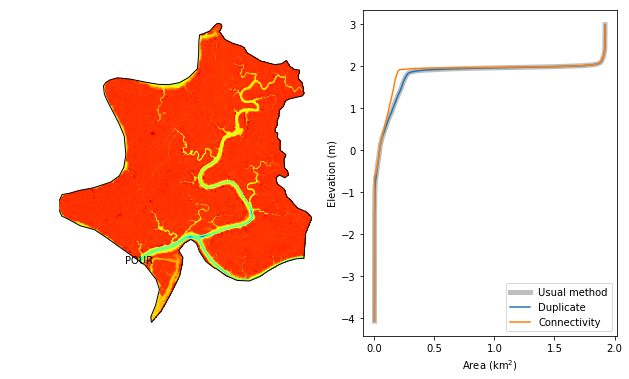

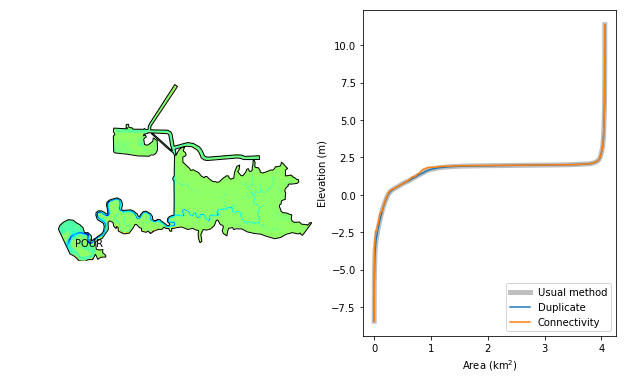

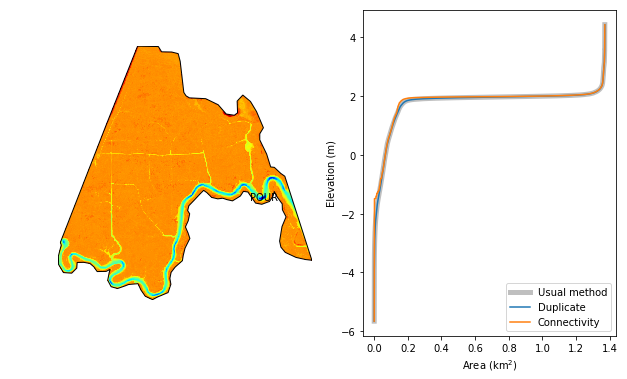

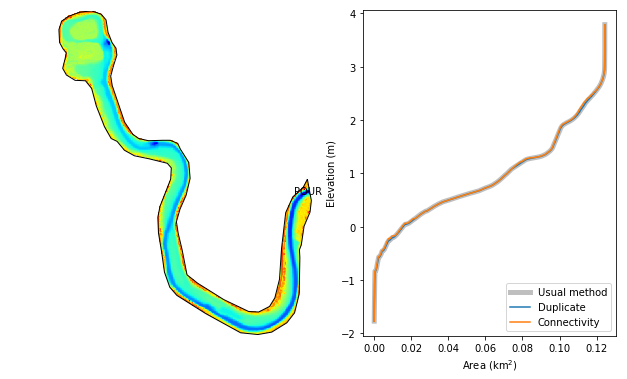

In [179]:
for rec in recs:
    display_html(f"<h3>{rec['name']}</h3>",raw=True)
    summary_figure(rec)

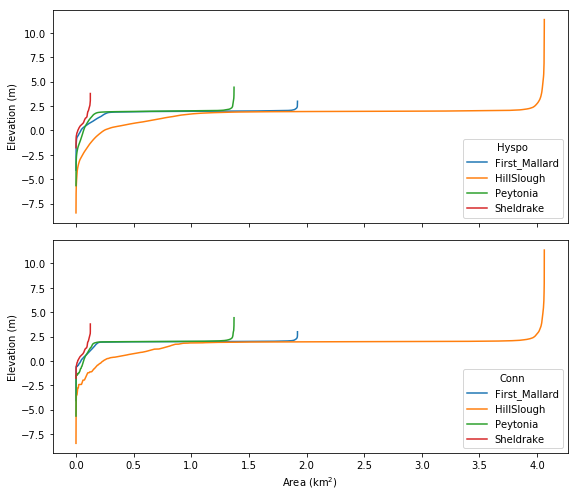

In [180]:
# Comparison plots for regular and connectivity-based hypsometry.
fig,axs=plt.subplots(2,1,sharex=True,sharey=True,figsize=(8,7))

for rec in recs:
    axs[0].plot(rec['area_hypso'][:,1]/1e6,
                rec['area_hypso'][:,0],label=rec['name'])
    axs[1].plot(rec['area_conn'][:,1]/1e6,
                rec['area_conn'][:,0],label=rec['name'])
    
axs[0].legend(title="Hyspo",loc='lower right')
axs[1].legend(title="Conn",loc="lower right")
axs[1].set_xlabel('Area (km$^2$)')
axs[0].set_ylabel('Elevation (m)')
axs[1].set_ylabel('Elevation (m)')
fig.tight_layout() 

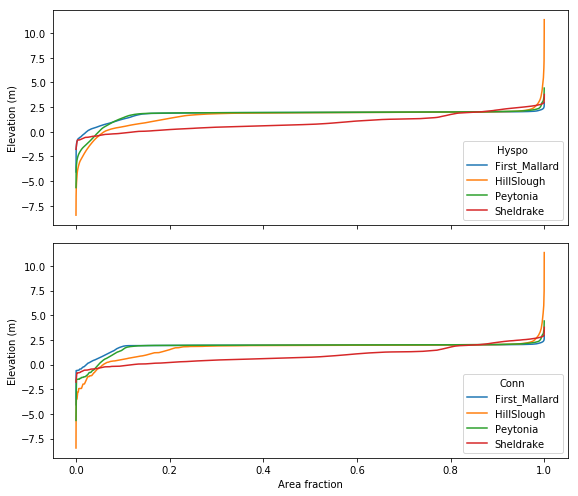

In [181]:
# Normalize to total area:
fig,axs=plt.subplots(2,1,sharex=True,sharey=True,figsize=(8,7))

for rec in recs:
    A=rec['geom'].area
    axs[0].plot(rec['area_hypso'][:,1]/A,
                rec['area_hypso'][:,0],label=rec['name'])
    axs[1].plot(rec['area_conn'][:,1]/A,
                rec['area_conn'][:,0],label=rec['name'])
    
axs[0].legend(title="Hyspo",loc='lower right')
axs[1].legend(title="Conn",loc="lower right")
axs[1].set_xlabel('Area fraction')
axs[0].set_ylabel('Elevation (m)')
axs[1].set_ylabel('Elevation (m)')
fig.tight_layout() 